/tmp/ipykernel_208964/2477690678.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promising_sellers['composite_score'] = (



=== Seller Analysis Report ===
Generated on: 2025-01-18 00:09:38

1. Dataset Overview:
Total Sellers: 1839
Non-Chinese Sellers: 1816

Country Distribution:
country
Other      1740
Unknown      75
CN           23
DE            1
Name: count, dtype: int64

2. Promising Sellers Summary:
Number of Promising Sellers: 142

Top 5 Promising Sellers:

Business Name: Business Name:Asia Pacific Elite Ltd
Country: Other
Product Count: 60,000
Rating: 94.0% (7,465 ratings)
Hero Product Ratings: 560, 481

Business Name: Business Name:Zoreno Versandhandel GmbH
Country: Other
Product Count: 100,000
Rating: 98.0% (2,630 ratings)
Hero Product Ratings: 25,802, 4,979

Business Name: Business Name:itenga GmbH
Country: Other
Product Count: 50,000
Rating: 91.0% (5,150 ratings)
Hero Product Ratings: 40,683, 18,910

Business Name: Business Name:trendmile GmbH
Country: Other
Product Count: 40,000
Rating: 89.0% (7,242 ratings)
Hero Product Ratings: 40,681, 13,311

Business Name: Business Name:Blumenbecker Indust

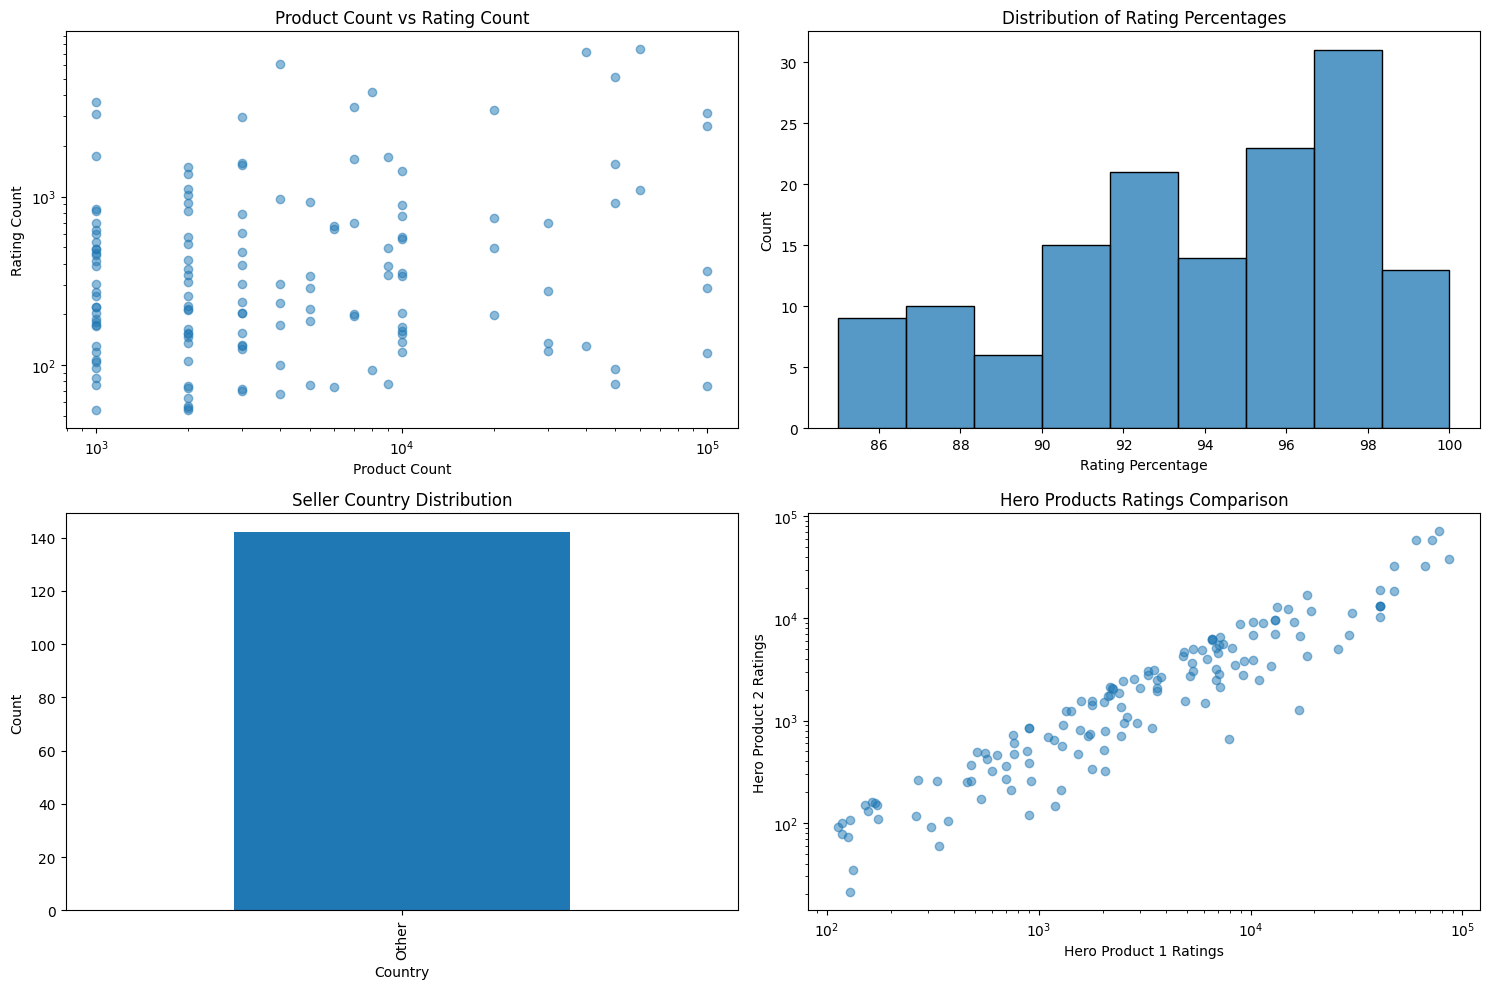

                phone                        email
1007                                              
1784                        ade.support@zoreno.com
36    06825 / 89697-0               info@itenga.de
726      06206, 06206        support@trendmile.com
23       02521/8406-0  bib.beckum@blumenbecker.com
...               ...                          ...
1482    0151 23758639                             
544    0261 960989 17             info@tdshop24.de
2                                                 
328                                               
391    05102 91 55 30           info@lotharjohn.de

[142 rows x 2 columns]


In [2]:
import pandas as pd
import numpy as np
import re
from typing import Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import openpyxl

class SellerAnalyzer:
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df = None
        self.processed_df = None

    def load_data(self) -> None:
        """Load data from the Excel file."""
        try:
            self.df = pd.read_excel(self.file_path)
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def process_data(self) -> None:
        """Process the data to extract relevant information."""
        self.processed_df = self.df.copy()
        self.processed_df['product_count'] = self.processed_df['sellerproductcount'].apply(self.extract_product_count)
        
        ratings_data = self.processed_df['sellerratings'].apply(self.extract_ratings)
        self.processed_df['rating_percentage'] = ratings_data.apply(lambda x: x[0])
        self.processed_df['rating_count'] = ratings_data.apply(lambda x: x[1])

        contact_info = self.processed_df['sellerdetails'].apply(self.extract_contact_info)
        self.processed_df['email'] = contact_info.apply(lambda x: x['email'])
        self.processed_df['phone'] = contact_info.apply(lambda x: x['phone'])
        
        self.processed_df['country'] = self.processed_df['businessaddress'].apply(self.determine_country)
        
        self.processed_df['hero_product_1_ratings'] = pd.to_numeric(self.processed_df['Hero Product 1 #ratings'], errors='coerce').fillna(0)
        self.processed_df['hero_product_2_ratings'] = pd.to_numeric(self.processed_df['Hero Product 2 #ratings'], errors='coerce').fillna(0)
        
        self.processed_df.to_excel('output.xlsx', index=False)

    def identify_promising_sellers(self, min_products: int = 1000, min_rating_percentage: float = 85.0, min_rating_count: int = 50, min_hero_ratings: int = 100) -> pd.DataFrame:
        """Identify promising sellers based on given criteria."""
        applicable_sellers = self.processed_df[self.processed_df['country'] != 'CN']
        promising_sellers = applicable_sellers[
            (applicable_sellers['product_count'] >= min_products) &
            (applicable_sellers['rating_percentage'] >= min_rating_percentage) &
            (applicable_sellers['rating_count'] >= min_rating_count) &
            ((applicable_sellers['hero_product_1_ratings'] >= min_hero_ratings) |
            (applicable_sellers['hero_product_2_ratings'] >= min_hero_ratings))
        ]
        
        promising_sellers['composite_score'] = (
            promising_sellers['rating_percentage'] * 
            np.log1p(promising_sellers['rating_count']) * 
            np.log1p(promising_sellers['product_count'])
        )
        return promising_sellers.sort_values('composite_score', ascending=False)

    def extract_ratings(self, text: str) -> Tuple[float, int]:
        """Extract rating percentage and count from text."""
        if pd.isna(text):
            return (0.0, 0)
        percentage_match = re.search(r'(\d+)%', text)
        count_match = re.search(r'(\d+)\s*ratings', text)
        percentage = float(percentage_match.group(1)) if percentage_match else 0.0
        count = int(count_match.group(1)) if count_match else 0
        return (percentage, count)
    
    def extract_product_count(self, text: str) -> int:
        """Extract product count from text."""
        if pd.isna(text):
            return 0
        match = re.search(r'over ([0-9,]+)', text)
        if match:
            return int(match.group(1).replace(',', ''))
        return 0
    
    def extract_contact_info(self, text: str) -> Dict[str, str]:
        """Extract email and phone number from text."""
        if pd.isna(text):
            return {'email': '', 'phone': ''}
        email_match = re.search(r'[\w\.-]+@[\w\.-]+\.\w+', text)
        phone_match = self.extract_phone_numbers(text)
        return {
            'email': email_match.group(0) if email_match else '',
            'phone': phone_match
        }
    
    def extract_phone_numbers(self, text: str) -> str:
        """Extract phone numbers from text."""
        phone_indicators = [
            r'Tel[:.\s]*', r'Telephone[:.\s]*', r'Telephon[:.\s]*', r'Telefon[:.\s]*', r'Telefonnummer[:.\s]*'
        ]
        phone_number_pattern = r'(\+?\d{1,4}[\s\-\/]?)?(\(?\d{1,4}\)?[\s\-\/]?)?[\d\s\-\/]{5,15}'
        combined_pattern = '|'.join(phone_indicators)
        
        matches = re.finditer(combined_pattern, text, re.IGNORECASE)
        phone_numbers = []
        
        for match in matches:
            phone_match = re.search(phone_number_pattern, text[match.end():])
            if phone_match:
                phone_numbers.append(phone_match.group().strip())
        
        return ', '.join(phone_numbers)

    def determine_country(self, address: str) -> str:
        """Determine the country from the address."""
        if pd.isna(address):
            return 'Unknown'
        address = address.upper()
        if 'CHINA' in address or 'CN)' in address:
            return 'CN'
        elif 'GERMANY' in address or 'DE)' in address:
            return 'DE'
        elif 'UNITED STATES' in address or 'US)' in address:
            return 'US'
        return 'Other'
    
    def generate_report(self, promising_sellers: pd.DataFrame) -> None:
        """Generate a report of the analysis."""
        print("\n=== Seller Analysis Report ===")
        print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        print("\n1. Dataset Overview:")
        print(f"Total Sellers: {len(self.df)}")
        print(f"Non-Chinese Sellers: {len(self.processed_df[self.processed_df['country'] != 'CN'])}")
        print("\nCountry Distribution:")
        print(self.processed_df['country'].value_counts())
        
        print("\n2. Promising Sellers Summary:")
        print(f"Number of Promising Sellers: {len(promising_sellers)}")
        print("\nTop 5 Promising Sellers:")

        top_5 = promising_sellers.head()

        for _, seller in top_5.iterrows():
            print(f"\nBusiness Name: {seller['seller business name']}")
            print(f"Country: {seller['country']}")
            print(f"Product Count: {seller['product_count']:,}")
            print(f"Rating: {seller['rating_percentage']}% ({seller['rating_count']:,} ratings)")
            print(f"Hero Product Ratings: {seller['hero_product_1_ratings']:,}, {seller['hero_product_2_ratings']:,}")
        
        print("\n3. Statistical Summary of Promising Sellers:")
        print(promising_sellers[['product_count', 'rating_percentage', 'rating_count']].describe())
    
    def create_visualizations(self, promising_sellers: pd.DataFrame) -> None:
        """Create visualizations for the analysis."""
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Product Count vs Rating Count
        plt.subplot(2, 2, 1)
        plt.scatter(promising_sellers['product_count'], promising_sellers['rating_count'], alpha=0.5)
        plt.xlabel('Product Count')
        plt.ylabel('Rating Count')
        plt.title('Product Count vs Rating Count')
        plt.xscale('log')
        plt.yscale('log')
        
        # 2. Distribution of rating percentages
        plt.subplot(2, 2, 2)
        sns.histplot(promising_sellers['rating_percentage'])
        plt.xlabel('Rating Percentage')
        plt.ylabel('Count')
        plt.title('Distribution of Rating Percentages')
        
        # 3. Country distribution
        plt.subplot(2, 2, 3)
        promising_sellers['country'].value_counts().plot(kind='bar')
        plt.xlabel('Country')
        plt.ylabel('Count')
        plt.title('Seller Country Distribution')
        
        # 4. Hero product ratings comparison
        plt.subplot(2, 2, 4)
        plt.scatter(promising_sellers['hero_product_1_ratings'], promising_sellers['hero_product_2_ratings'], alpha=0.5)
        plt.xlabel('Hero Product 1 Ratings')
        plt.ylabel('Hero Product 2 Ratings')
        plt.title('Hero Products Ratings Comparison')
        plt.xscale('log')
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()

def main():
    analyzer = SellerAnalyzer('Sample_Longlist_Data.xlsx')
    analyzer.load_data()
    analyzer.process_data()
    
    sellers = analyzer.identify_promising_sellers(
        min_products=1000,
        min_rating_percentage=85.0,
        min_rating_count=50,
        min_hero_ratings=100
    )
    
    analyzer.generate_report(sellers)
    analyzer.create_visualizations(sellers)
    print(sellers[['phone', 'email']])
    
if __name__ == "__main__":
    main()